In [3]:
%%file dataset.py
# Generate training dataset and test dataset.
from constant import *
import os
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import xml.etree.ElementTree as ET
import copy
import random
import time
import argparse
import math

#### Parameters. ####
parser = argparse.ArgumentParser()
parser.add_argument('--dataset_index', required=True)
parser.add_argument('--type_str', required=True)
args = parser.parse_args()

#type_str = 'nocrop' # {1k_}[crop | nocrop | crop_obj | nocrop_obj | aperture]
type_str = args.type_str

#dataset = [(0.0, 0), (1.0/4, 4), (1.0/3, 3), (1.0/2, 3), (2.0/3, 3), (4.0/5, 3), (9.0/10, 3), (1.0, 1)]
#dataset = [(0.0, 0), (0.1, 10), (0.2, 5), (0.3, 4), (0.4, 3), (0.5, 3), (0.6, 3), (0.7, 3), (0.8, 3), (0.9, 3), (1.0, 1)]
#dataset = [(0.0, 0), (0.2, 9), (0.4, 9), (0.6, 9), (0.8, 9), (1.0, 9)] # when crop_obj or nocrop_obj, (size, total_num)
dataset = [(0.0, 0),  (0.1, 10), (0.2, 10), (0.3, 10), (0.4, 10),\
           (0.5, 10), (0.6, 10), (0.7, 10), (0.8, 10), (0.9, 10), (1.0, 1)]
dataset_index = int(args.dataset_index)
#dataset_index = 5
print 'Processsing dataset {}, type_str {}'.format(dataset[dataset_index], type_str)
dataset = [dataset[dataset_index]]

# divide to training dataset and test dataset
training_dataset_size = 300
validation_dataset_size = 100
test_dataset_size = 100

# obj image: always 1024 * 768 pixels
obj_width = 1024
obj_height = 768
obj_ratio = float(obj_width) / obj_height
#####################

mean_color = (123, 117, 104)

# Load labels.
imagenet_labels_filename = imagenet_root + 'ilsvrc12/synset_words.txt'
label_to_wnid = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
wnid_to_label = {}
for label in range(len(label_to_wnid)):
    wnid = label_to_wnid[label].split(' ')[0]
    wnid_to_label[wnid] = label

train_folders = []
val_folders = []
test_folders = []

train_files = []
val_files = []
test_files = []

for (slider_size, slider_num) in dataset:
    percent = str(int(100 * slider_size))
    f = open('{}dataset/train_{}_{}.txt'.format(imagenet_root, type_str, percent), 'w')
    train_files.append(f)
    
    folder = '{}dataset/train_{}_{}/'.format(imagenet_root, type_str, percent)
    if not os.path.exists(folder):
        os.makedirs(folder)
    train_folders.append(folder)

for (slider_size, slider_num) in dataset:
    percent = str(int(100 * slider_size))
    f = open('{}dataset/val_{}_{}.txt'.format(imagenet_root, type_str, percent), 'w')
    val_files.append(f)

    folder = '{}dataset/val_{}_{}/'.format(imagenet_root, type_str, percent)
    if not os.path.exists(folder):
        os.makedirs(folder)
    val_folders.append(folder)

for (slider_size, slider_num) in dataset:
    percent = str(int(100 * slider_size))
    f = open('{}dataset/test_{}_{}.txt'.format(imagenet_root, type_str, percent), 'w')
    test_files.append(f)

    folder = '{}dataset/test_{}_{}/'.format(imagenet_root, type_str, percent)
    if not os.path.exists(folder):
        os.makedirs(folder)
    test_folders.append(folder)
    
if 'obj' in type_str:
    obj_images = []
    for i, image_name in enumerate(os.listdir(shapenet_root + 'object_nobg/')):
        img_temp = Image.open(shapenet_root + 'object_nobg/' + image_name)
        img = img_temp.copy()
        img_temp.close()
        #img = img.convert("RGBA")
        obj_images.append(img)
    print "{} object occluders loaded.".format(len(obj_images))

# occluder size = slider_size * slider_size
# occluder num = slider_num * slider_num
# path = 'imagenet_root/dataset/train_0/name'
# {wnid_imgid}_{crop/nocrop}_{rect_i(ifcrop)}_{slider_size}_{i}_{j}
def generate_datum(img_orig, path, f, class_id, rects, slider_size, slider_num):
    if type_str == 'crop' or type_str == '1k_crop':
        if slider_size == 0:
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                img = img.crop(rect)
                datum_path = '{}_{}_{}_0_0.jpeg'.format(path, type_str, rect_i)
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for rect_i, rect in enumerate(rects):
                for i in range(slider_num):
                    img = img_orig.copy()
                    d = ImageDraw.Draw(img)
                    slider_width = int((rect[2] - rect[0]) * math.sqrt(slider_size))
                    slider_height = int((rect[3] - rect[1]) * math.sqrt(slider_size))
                    subrect = [0, 0, 0, 0]
                    subrect[0] = random.randint(rect[0], rect[2] - slider_width)
                    subrect[1] = random.randint(rect[1], rect[3] - slider_height)
                    subrect[2] = subrect[0] + slider_width
                    subrect[3] = subrect[1] + slider_height
                    d.rectangle(subrect, fill=mean_color, outline=None)
                    img = img.crop(rect)
                    datum_path = '{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)), i)
                    img.save(datum_path)
                    f.write('{} {}\n'.format(datum_path, str(class_id)))
    if type_str == 'nocrop' or type_str == '1k_nocrop':
        if slider_size == 0:
            datum_path = '{}_{}_0_0_0.jpeg'.format(path, type_str)
            img_orig.save(datum_path)
            f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for i in range(slider_num):
                img = img_orig.copy()
                d = ImageDraw.Draw(img)
                for rect in rects:
                    slider_width = int((rect[2] - rect[0]) * math.sqrt(slider_size))
                    slider_height = int((rect[3] - rect[1]) * math.sqrt(slider_size))
                    subrect = [0, 0, 0, 0]
                    subrect[0] = random.randint(rect[0], rect[2] - slider_width)
                    subrect[1] = random.randint(rect[1], rect[3] - slider_height)
                    subrect[2] = subrect[0] + slider_width
                    subrect[3] = subrect[1] + slider_height
                    d.rectangle(subrect, fill=mean_color, outline=None)
                datum_path = '{}_{}_{}_{}_{}.jpeg'.format(path, type_str, 0, str(int(100 * slider_size)), i)
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))                    
    
    if type_str == 'crop_obj' or type_str == '1k_crop_obj':
        if slider_size == 0:
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                img = img.crop(rect)
                datum_path = '{}_{}_{}_{}_0.jpeg'.format(path, type_str, rect_i, int(100 * slider_size))
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for rect_i, rect in enumerate(rects):
                for num in range(slider_num):
                    img = img_orig.copy()
                    random_obj = obj_images[random.randint(0, len(obj_images) - 1)].copy()
                    width = rect[2] - rect[0]
                    height = rect[3] - rect[1]
                    ratio = float(width) / height
                    if ratio >= obj_ratio:
                        resize_scale = float(height) / obj_height * slider_size
                    else:
                        resize_scale = float(width) / obj_width * slider_size
                    new_width = int(obj_width * resize_scale)
                    new_height = int(obj_height * resize_scale)
                    if new_width == 0:
                        new_width = 1
                    if new_height == 0:
                        new_height = 1
                    random_obj = random_obj.resize((new_width, new_height), Image.ANTIALIAS)
                    
                    rangex = [rect[0], rect[2] - random_obj.size[0]]
                    if rangex[1] < rangex[0]:
                        rangex[1] = rangex[0]
                        
                    rangey = [rect[1], rect[3] - random_obj.size[1]]
                    if rangey[1] < rangey[0]:
                        rangey[1] = rangey[0]
                    top_left = (random.randint(rangex[0], rangex[1]), random.randint(rangey[0], rangey[1]))
                    img.paste(random_obj, top_left, random_obj)
                    img = img.crop(rect)
                    datum_path = '{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, int(100 * slider_size), num)
                    img.save(datum_path)
                    f.write('{} {}\n'.format(datum_path, str(class_id)))
                    
    if type_str == 'nocrop_obj' or type_str == '1k_nocrop_obj':
        if slider_size == 0:
            datum_path = '{}_{}_{}_{}_0.jpeg'.format(path, type_str, 0, int(100 * slider_size))
            img_orig.save(datum_path)
            f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for num in range(slider_num):
                img = img_orig.copy()
                for rect_i, rect in enumerate(rects):
                    random_obj = obj_images[random.randint(0, len(obj_images) - 1)].copy()
                    width = rect[2] - rect[0]
                    height = rect[3] - rect[1]
                    ratio = float(width) / height
                    if ratio >= obj_ratio:
                        resize_scale = float(height) / obj_height * slider_size
                    else:
                        resize_scale = float(width) / obj_width * slider_size
                    new_width = int(obj_width * resize_scale)
                    new_height = int(obj_height * resize_scale)
                    if new_width == 0:
                        new_width = 1
                    if new_height == 0:
                        new_height = 1
                    random_obj = random_obj.resize((new_width, new_height), Image.ANTIALIAS)
                    
                    rangex = [rect[0], rect[2] - random_obj.size[0]]
                    if rangex[1] < rangex[0]:
                        rangex[1] = rangex[0]
                        
                    rangey = [rect[1], rect[3] - random_obj.size[1]]
                    if rangey[1] < rangey[0]:
                        rangey[1] = rangey[0]
                    top_left = (random.randint(rangex[0], rangex[1]), random.randint(rangey[0], rangey[1]))
                    img.paste(random_obj, top_left, random_obj)
                    
                datum_path = '{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, int(100 * slider_size), num)
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))              
                    
                    
    if type_str == 'aperture' or type_str == '1k_aperture':
        if slider_size == 0: # All black.
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                d = ImageDraw.Draw(img)
                d.rectangle(rect, fill="black", outline=None)
                img = img.crop(rect)
                datum_path = '{}_{}_{}_{}_0_0.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)))
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        elif slider_size == 1: # All visible. 
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                img = img.crop(rect)
                datum_path = '{}_{}_{}_{}_0_0.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)))
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for rect_i, rect in enumerate(rects):
                for i in range(slider_num):
                    for j in range(slider_num):
                        img = img_orig.copy()
                        d = ImageDraw.Draw(img)
                        delta = (1 - slider_size) / float(slider_num - 1)
                        subrect = [0, 0, 0, 0]
                        subrect[0] = rect[0] + i * (rect[2] - rect[0]) * delta
                        subrect[1] = rect[1] + j * (rect[3] - rect[1]) * delta
                        subrect[2] = subrect[0] + (rect[2] - rect[0]) * slider_size
                        subrect[3] = subrect[1] + (rect[3] - rect[1]) * slider_size
                        d.rectangle([0, 0, img.size[0], subrect[1]], fill="black", outline=None)
                        d.rectangle([0, 0, subrect[0], img.size[1]], fill="black", outline=None)
                        d.rectangle([subrect[2], 0, img.size[0], img.size[1]], fill="black", outline=None)
                        d.rectangle([0, subrect[3], img.size[0], img.size[1]], fill="black", outline=None)
                        img = img.crop(rect)
                        datum_path = '{}_{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)), str(i), str(j))
                        img.save(datum_path)
                        f.write('{} {}\n'.format(datum_path, str(class_id)))
            
image_path = imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/'
annotation_path =  imagenet_root + 'ILSVRC2015/Annotations/CLS-LOC/train/'

if '1k' in type_str:
    synset_names = os.listdir(image_path)
            
start_time = time.time()

dataset_sum = training_dataset_size + validation_dataset_size + test_dataset_size
all_sum = len(synset_names) * dataset_sum
print all_sum

for synset_index, synset_name in enumerate(synset_names):
    image_names = os.listdir(image_path + synset_name)
    annotation_names = os.listdir(annotation_path + synset_name)
    n1 = [os.path.splitext(n)[0] for n in image_names]
    n2 = [os.path.splitext(n)[0] for n in annotation_names]
    intersection_names = list(set(n1) & set(n2))
    for i in range(dataset_sum):
        if (i + 1) % 50 == 0:
            second = int(time.time() - start_time)
            now_time = time.strftime("%H:%M:%S", time.gmtime(second))
            now_sum = synset_index * dataset_sum + i
            
            estimated = int(float(all_sum) / now_sum * second)
            estimated_time = time.strftime("%H:%M:%S", time.gmtime(estimated))
            estimated_day = estimated / 3600 / 24
            print '[{}/{} {}]Processing synset [{}/{}], image [{}/{}]: {}'.format(now_time, estimated_day, estimated_time, synset_index + 1, len(synset_names), i + 1, dataset_sum, intersection_names[i])
        # Read bounding box.
        bbx_file = open(annotation_path + synset_name + '/' + intersection_names[i] + '.xml')
        xmltree = ET.parse(bbx_file)
        objects = xmltree.findall('object')
        rects = []
        for obj in objects:
            bbx = obj.find('bndbox')
            rects.append([int(it.text) for it in bbx])
            
        img_orig = Image.open(image_path + synset_name + '/' + intersection_names[i] + '.JPEG')
        if img_orig.mode != "RGB":
            img_orig = img_orig.convert("RGB")
            
        if '1k' in type_str:
            class_id = wnid_to_label[synset_name]
        else:
            class_id = original_to_new_class_id[wnid_to_label[synset_name]]
        
        if i < training_dataset_size: # Training dataset. 
            for index, (slider_size, slider_num) in enumerate(dataset):
                generate_datum(img_orig, '{}{}'.format(train_folders[index], intersection_names[i]), \
                               train_files[index], class_id, rects, slider_size, slider_num)
        elif i < training_dataset_size + validation_dataset_size: # Validation dataset
            for index, (slider_size, slider_num) in enumerate(dataset):
                generate_datum(img_orig, '{}{}'.format(val_folders[index], intersection_names[i]), \
                               val_files[index], class_id, rects, slider_size, slider_num)
        else: # Test dataset.
            for index, (slider_size, slider_num) in enumerate(dataset):
                generate_datum(img_orig, '{}{}'.format(test_folders[index], intersection_names[i]), \
                               test_files[index], class_id, rects, slider_size, slider_num)
                               
for f in train_files:
    f.close()
for f in test_files:
    f.close()
            

Overwriting dataset.py


In [3]:
# Sample or for lmdb.

import os
import random
from constant import *
import shutil

mode = 'nosample'
is_lmdb = True

func_strs = ['train', 'val', 'test']
type_strs = ['crop', 'nocrop']
names = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
sample_sum = {'train': 100000, 'test': 50000}

for func_str in func_strs:
    for type_str in type_strs:
        for name in names:
            #shutil.copyfile('{}dataset/{}_{}_{}.txt'.format(imagenet_root, func_str, type_str, name), \
            #         '{}dataset/{}_{}_{}_unsampled.txt'.format(imagenet_root, func_str, type_str, name))
            with open('{}dataset/{}_{}_{}_unsampled.txt'.format(imagenet_root, func_str, type_str, name)) as f:
                lines = f.readlines()
            if mode == 'nosample':
                sampled = lines
            else:
                sampled = random.sample(lines, sample_sum[func_str])
            if is_lmdb:
                for i in range(len(sampled)):
                    sampled[i] = sampled[i].split('/')[-2] + '/' + sampled[i].split('/')[-1]
            with open('{}dataset/{}_{}_{}.txt'.format(imagenet_root, func_str, type_str, name), 'w') as f:
                f.writelines(sampled)

In [6]:
# Create {}_{}_all.txt.
import os
import random
from constant import *

type_strs = ['crop', 'nocrop']
func_strs = ['train', 'val', 'test']
#names = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
names = ['0', '20', '40', '60', '80', '100']
sample_sum = {'train': {'crop': 343360, 'nocrop': 300000}, \
              'val': {'crop': 114010, 'nocrop': 100000}, \
              'test': {'crop': 114060, 'nocrop': 100000}}

for func_str in func_strs:
    for type_str in type_strs:
        lines = []
        for name in names:
            f = open('{}dataset/{}_{}_{}.txt'.format(imagenet_root, func_str, type_str, name), 'r')
            ls = f.readlines()
            f.close()
            lines = lines + ls
        f = open('{}dataset/{}_{}_all_unsampled.txt'.format(imagenet_root, func_str, type_str), 'w')
        f.writelines(lines)
        f.close()
        
        
        sampled = random.sample(lines, sample_sum[func_str][type_str])
        f = open('{}dataset/{}_{}_all.txt'.format(imagenet_root, func_str, type_str), 'w')
        f.writelines(sampled)
        f.close()

In [ ]:
#%%file transparent.py
# Make white color transparent.
from constant import *
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import numpy as np
import os

image_names = os.listdir(shapenet_root + 'object_orig/')
print len(image_names)

for i, image_name in enumerate(image_names):
    print '[{}/{}]: {}'.format(i, len(image_names), image_name)
    img = Image.open(shapenet_root + 'object_orig/' + image_name)
    
    img = img.convert("RGBA")
    pixdata = img.load()
    for y in xrange(img.size[1]):
        for x in xrange(img.size[0]):
            if pixdata[x, y] == (255, 255, 255, 255):
                pixdata[x, y] = (255, 255, 255, 0)
    img.save(shapenet_root + 'object_nobg/' + image_name, 'PNG')


In [8]:
# Show typical images of each class.
from constant import *
import os
import numpy as np
#from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import copy
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import Image, display


imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
with open(imagenet_labels_filename) as f:
    lines = f.readlines()
wnid_to_name = {}
for line in lines:
    wnid = line.split(' ')[0]
    name = line[(len(wnid) + 1):-1]
    wnid_to_name[wnid] = name

image_path = imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/'
for synset_name in synset_names:
    image_names = os.listdir(image_path + synset_name)
    print wnid_to_name[synset_name], 'http://image-net.org/synset?wnid=' + synset_name
    #display(Image(filename=image_path + synset_name + '/' + image_names[0]))
    
    
    

sewing machine http://image-net.org/synset?wnid=n04179913
parking meter http://image-net.org/synset?wnid=n03891332
hard disc, hard disk, fixed disk http://image-net.org/synset?wnid=n03492542
hyena, hyaena http://image-net.org/synset?wnid=n02117135
three-toed sloth, ai, Bradypus tridactylus http://image-net.org/synset?wnid=n02457408
fur coat http://image-net.org/synset?wnid=n03404251
Arctic fox, white fox, Alopex lagopus http://image-net.org/synset?wnid=n02120079
great grey owl, great gray owl, Strix nebulosa http://image-net.org/synset?wnid=n01622779
scoreboard http://image-net.org/synset?wnid=n04149813
cinema, movie theater, movie theatre, movie house, picture palace http://image-net.org/synset?wnid=n03032252
tusker http://image-net.org/synset?wnid=n01871265
window screen http://image-net.org/synset?wnid=n04589890
sock http://image-net.org/synset?wnid=n04254777
tiger, Panthera tigris http://image-net.org/synset?wnid=n02129604
saltshaker, salt shaker http://image-net.org/synset?wnid=n0

In [4]:
# Sanity check.
import os
from constant import *

func_strs = ['train', 'val', 'test']
type_strs = ['nocrop', 'crop']
names = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', 'all']

for func_str in func_strs:
    for type_str in type_strs:
        for name in names:
            filename = '{}dataset/{}_{}_{}.txt'.format(imagenet_root, func_str, type_str, name) 
            f = open(filename)
            lines = f.readlines()
            f.close()
            print '{:10d} {}'.format(len(lines), filename)

     30000 /data2/haow3/data/imagenet/dataset/train_nocrop_0.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_10.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_20.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_30.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_40.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_50.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_60.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_70.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_80.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_90.txt
     30000 /data2/haow3/data/imagenet/dataset/train_nocrop_100.txt
    300000 /data2/haow3/data/imagenet/dataset/train_nocrop_all.txt
     34336 /data2/haow3/data/imagenet/dataset/train_crop_0.txt
    343360 /data2/haow3/data/imagenet/dataset/train_crop_10.txt
    343360 /data2/haow3/data/imagenet/dataset/train_crop_20.txt
    343360 /data

In [ ]:
import os
from constant import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = open(caffe_root + 'data/ilsvrc12/synset_words.txt')
label_to_wnid = f.readlines()
wnid_to_label = {}
for label in range(len(label_to_wnid)):
    wnid = label_to_wnid[label].split(' ')[0]
    wnid_to_label[wnid] = label

folders = os.listdir(imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/')
count = []
for folder in folders:
    image_names = os.listdir(imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/' + folder)
    annotation_names = os.listdir(imagenet_root + 'ILSVRC2015/Annotations/CLS-LOC/train/' + folder)
    n1 = [os.path.splitext(n)[0] for n in image_names]
    n2 = [os.path.splitext(n)[0] for n in annotation_names]
    intersection_names = list(set(n1) & set(n2))
    count.append(len(intersection_names))

x = [i for i in range(len(count))]
count = sorted(count)
plt.plot(x, count)

['n04179913', 'n03891332', 'n03492542', 'n02117135', 'n02457408', 'n03404251', 'n02120079', 'n01622779', 'n04149813', 'n03032252', 'n01871265', 'n04589890', 'n04254777', 'n02129604', 'n04131690', 'n02108089', 'n07753592', 'n03692522', 'n04540053', 'n02883205', 'n03532672', 'n02509815', 'n03271574', 'n09193705', 'n03770439', 'n02002556', 'n02086079', 'n04118776', 'n04229816', 'n02168699', 'n04486054', 'n02442845', 'n01882714', 'n04612504', 'n03776460', 'n02321529', 'n03980874', 'n04049303', 'n04209133', 'n01729977', 'n07860988', 'n04162706', 'n02099601', 'n02704792', 'n04553703', 'n01833805', 'n02666196', 'n03372029', 'n04613696', 'n02504013', 'n04357314', 'n07697537', 'n02106662', 'n02486410', 'n02112018', 'n04356056', 'n02012849', 'n02123597', 'n04141076', 'n02443114', 'n03787032', 'n07754684', 'n03527444', 'n02777292', 'n02494079', 'n02085620', 'n07718747', 'n03874599', 'n01682714', 'n01443537', 'n02510455', 'n03841143', 'n02492660', 'n03028079', 'n01687978', 'n01943899', 'n02137549'

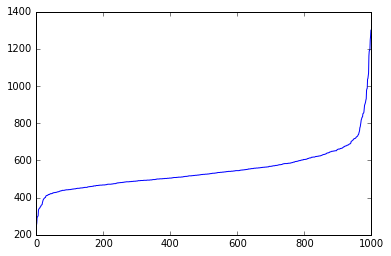

In [19]:
# Randomly sample classes for experiment.
import os
from constant import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random


imagenet_labels_filename = imagenet_root + 'ilsvrc12/synset_words.txt'
label_to_wnid = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

synset_name_to_original_id = {}
for original_id in range(len(label_to_wnid)):
    synset_name = label_to_wnid[original_id].split(' ')[0]
    synset_name_to_original_id[synset_name] = original_id

image_path = imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/'
annotation_path =  imagenet_root + 'ILSVRC2015/Annotations/CLS-LOC/train/'

count = []
sampled = []
for synset_index, synset_name in enumerate(os.listdir(image_path)):
    image_names = os.listdir(image_path + synset_name)
    annotation_names = os.listdir(annotation_path + synset_name)
    n1 = [os.path.splitext(n)[0] for n in image_names]
    n2 = [os.path.splitext(n)[0] for n in annotation_names]
    intersection_names = list(set(n1) & set(n2))
    count.append(len(intersection_names))
    if len(intersection_names) >= 500:
        sampled.append(synset_name)

count = sorted(count)
plt.plot(count)

sampled = random.sample(sampled, 100)
print sampled

new_to_original_class_id = []
original_to_new_class_id = {}
for synset_name in sampled:
    new_to_original_class_id.append(synset_name_to_original_id[synset_name])
new_to_original_class_id = sorted(new_to_original_class_id)
print new_to_original_class_id

for i, original_id in enumerate(new_to_original_class_id):
    original_to_new_class_id[original_id] = i
print original_to_new_class_id

In [20]:
# Generate label list.
import os
from constant import *

imagenet_labels_filename = imagenet_root + 'ilsvrc12/synset_words.txt'
lines = open(imagenet_labels_filename).readlines()

original_id_to_name = []
for line in lines:
    wnid = line.split(' ')[0]
    name = line[(len(wnid) + 1):-1]
    original_id_to_name.append(name)
    
    
label = [None for i in range(len(synset_names))]

for new_id, original_id in enumerate(new_to_original_class_id):
    label[new_id] = original_id_to_name[original_id]
    print label[new_id]
    
    

goldfish, Carassius auratus
great grey owl, great gray owl, Strix nebulosa
American chameleon, anole, Anolis carolinensis
agama
green snake, grass snake
hummingbird
tusker
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
conch
white stork, Ciconia ciconia
crane
oystercatcher, oyster catcher
Chihuahua
Pekinese, Pekingese, Peke
Norfolk terrier
Norwich terrier
golden retriever
German shepherd, German shepherd dog, German police dog, alsatian
boxer
Eskimo dog, husky
Pomeranian
hyena, hyaena
Arctic fox, white fox, Alopex lagopus
Siamese cat, Siamese
tiger, Panthera tigris
mongoose
ground beetle, carabid beetle
long-horned beetle, longicorn, longicorn beetle
cabbage butterfly
sea cucumber, holothurian
porcupine, hedgehog
Arabian camel, dromedary, Camelus dromedarius
mink
polecat, fitch, foulmart, foumart, Mustela putorius
three-toed sloth, ai, Bradypus tridactylus
gibbon, Hylobates lar
baboon
howler monkey, howler
squirrel monkey, Saimiri sciureus
Indian elephant, Elepha